In [1]:
# compile and analysis of 
# the timeseries (or its mean) of OmF, VarBC increment, VarBC-induced cloud increment
# (1) compile the radstats (by each cycle) into pkl files
# (2) do the time-mean analysis of OmF, VarBC increment, VarBC normalized increment (change in obs forcing)

# initial built: 2024/12/20 (original = compiled_radstat_omf_omfnbc_cloud_Hovemoller.ipynb)
# modified: 2025/02/13
# revised: 2025/04/22: also include cloud increment analysis due to VarBC

# This has been transformed into py file:
# /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/varbc_and_omf_vs_cloud_analysis/varbc_and_omf_vs_cloud_analysis_driver.sh

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import pickle

In [27]:
instrument = 'atms'
channel    = 'ch1'
#exps = ['full_CTRL','full_clr_cld', 'full_sym_bc', 'full_sym_clwnbc', 'full_sym_tri']
exps = ['full_CTRL','full_clr_cld', 'full_CTRL_low_sym', 'full_low_sym_tri']

expref = exps[0]
expstr = '-'.join(exps)

read_pkl = False

init_time  = datetime(2022, 6, 20,  0, 0, 0)  # Year, month, day, hour, minute, second
final_time = datetime(2022, 8, 10,  0, 0, 0)  # Year, month, day, hour, minute, second
sdate = init_time.strftime('%Y%m%d')
edate = final_time.strftime('%Y%m%d')

dt         = 12 # in hours

# Calculate the total time difference in hours
total_hours = (final_time - init_time).total_seconds() / 3600

# Calculate the number of timesteps
nt = int(total_hours / dt) +1

# define the cloud bins
x_cld = np.linspace(0,1,41)
nc    = len(x_cld) - 1 # number of cloud bins

def smoothing(raw):
    len_input = len(raw)
    smoothed = np.zeros(len_input)
    
    for i, raw_in in enumerate(raw):
        if i <= 16:
            smoothed[i] = raw_in
        elif i>16 and i<=24:
            smoothed[i] = (raw[i-1] + raw[i] + raw[i+1])/3
        elif i>24 and i<=37:
            smoothed[i] = (raw[i-2] + raw[i-1] + raw[i] + raw[i+1] + raw[i+2])/5
        elif i==38:
            smoothed[i] = (raw[i-2] + raw[i-1] + raw[i] + raw[i+1])/4
        elif i==39:
            smoothed[i] = (raw[i-2] + raw[i-1] + raw[i])/3
            
    return smoothed

# define the how to "bin" the clouds:
#cloud_predictor_name = ['Obs Cloud']
cloud_predictor_name = ['Symmetric Cloud','Model Cloud', 'Obs Cloud']

save_figure = False
fig_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/varBC_and_omf_vs_cloud_analysis/{expstr}'

if save_figure:
    os.makedirs(fig_dir, exist_ok=True)
    print(f"Directory '{fig_dir}' created.")
        
expshort = {'full_CTRL'      : 'CTRL',
            'full_clr_cld'   : 'CLR-CLD',
            'full_only_clr'  : 'CLR',
            'full_sym_tri'   : 'CLR-CLD_SYM',
            'full_sym_clwnbc': 'POLY_NOBC',
            'full_sym_bc'    : 'POLY_BC',  
            'full_low_sym_tri': 'CLR-CLD_SYM_LOW', 
            'full_CTRL_low_sym': 'CTRL_SYM_LOW'}

expcolor = {'full_CTRL': 'black', 
            'full_only_clr': 'gray', 
            'full_clr_cld' : 'blue', 
            'full_sym_tri' : 'green', 
            'full_low_sym_tri':  'orange', 
            'full_CTRL_low_sym': 'olive', 
            'full_sym_bc':       'brown',
            'full_sym_clwnbc':   'purple'  }

In [28]:
if read_pkl:
    dic_ndata={};
    dic_omf={};
    dic_omfnbc={};
    dic_omfnorm    = {};
    dic_omfnbcnorm = {};
    dic_cldinc     = {};

    for exp in exps:
        save_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/compile_radstats/pkl_files_omf_cloud/{exp}'
        pkfile = f'{save_dir}/{exp}_{instrument}_{channel}_{sdate}_{edate}.pkl'

        with open(pkfile, 'rb') as file:
            data = pickle.load(file)

        dic_ndata[exp]  = data['dic_ndata']
        dic_omf[exp]    = data['dic_omf']
        dic_omfnbc[exp] = data['dic_omfnbc']
        dic_omfnorm[exp]    = data['dic_omfnorm']
        dic_omfnbcnorm[exp] = data['dic_omfnbcnorm']
        dic_cldinc[exp] = data['dic_cldinc']
        
else:

    import warnings

    # Suppress all warnings
    warnings.filterwarnings("ignore")

    dic_ndata  = {};
    dic_omf    = {};
    dic_omfnbc = {};
    dic_omfnorm    = {};
    dic_omfnbcnorm = {};
    dic_cldinc = {};
    
    datetime_ticks  = [];

    for e, exp in enumerate(exps):

        print(f'now processing {exp}...')

        dic_ndata[exp]={}; 
        dic_omf[exp]={};
        dic_omfnbc[exp]={};
        dic_omfnorm[exp]={};
        dic_omfnbcnorm[exp]={};
        dic_cldinc[exp]={};

        current_time = init_time

        ndata_sym  = np.zeros((nt,nc));
        omf_sym    = np.zeros((nt,nc));
        omfnbc_sym = np.zeros((nt,nc));
        omfnorm_sym    = np.zeros((nt,nc));
        omfnbcnorm_sym = np.zeros((nt,nc));
        cldinc_sym = np.zeros((nt,nc));
        
        ndata_obs  = np.zeros((nt,nc));
        omf_obs    = np.zeros((nt,nc));
        omfnbc_obs = np.zeros((nt,nc));
        omfnorm_obs    = np.zeros((nt,nc));
        omfnbcnorm_obs = np.zeros((nt,nc));
        cldinc_obs = np.zeros((nt,nc));
        
        
        ndata_model  = np.zeros((nt,nc));
        omf_model    = np.zeros((nt,nc));
        omfnbc_model = np.zeros((nt,nc));
        omfnorm_model    = np.zeros((nt,nc));
        omfnbcnorm_model = np.zeros((nt,nc));
        cldinc_model = np.zeros((nt,nc));
        
        tt=0;

        while current_time <= final_time:

            cdate  = current_time.strftime("%Y%m%d%H")

            if e==0:
                datetime_ticks.append(cdate)

            if np.mod(tt,20) ==0:
                print(f'     time = {cdate}')

            root_path = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/compile_radstats/csv_files'
            fn = f'/{exp}/each_cycle/{cdate}/omf_stats_{instrument}_{channel}_{cdate}.csv'
            tmpdf=pd.read_csv(f'{root_path}/{fn}')

            # dfs = data frame screend
            #screen = ( tmpdf['errinv_ges'] >0 )
            screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 )
            #screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 ) & ( tmpdf['varbc_idx_ges']==1 )
            dfs = tmpdf.loc[screen]
            
            dfs['clw_sym'] = 0.5*(dfs['clw_obs'] + dfs['clw_bg_nobc_ges']) # raw symmetric cloud

            for cld_pred in cloud_predictor_name:


                for i in range(nc):

                    if cld_pred == 'Obs Cloud':
                        cld_screen = (dfs['clw_obs'] >= x_cld[i]) & (dfs['clw_obs'] < x_cld[i+1])
                        dfs_cld = dfs.loc[cld_screen]

                        ndata_obs[tt,i]  = dfs_cld.shape[0]
                        omf_obs[tt,i]     = np.mean(dfs_cld['omf_ges'])
                        omfnbc_obs[tt,i]  = np.mean(dfs_cld['omfnbc_ges'])
                        omfnorm_obs[tt,i]    = np.mean(dfs_cld['omf_ges']*dfs_cld['errinv_ges']**2)
                        omfnbcnorm_obs[tt,i] = np.mean(dfs_cld['omfnbc_ges']*dfs_cld['errinv_ges']**2)
                        
                        cld_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']
                        cldinc_obs[tt,i] = np.nanmean(cld_inc)
                        
                    elif cld_pred == 'Model Cloud':
                        cld_screen = (dfs['clw_bg_nobc_ges'] >= x_cld[i]) & (dfs['clw_bg_nobc_ges'] < x_cld[i+1])
                        dfs_cld = dfs.loc[cld_screen]

                        ndata_model[tt,i] = dfs_cld.shape[0]
                        omf_model[tt,i]    = np.mean(dfs_cld['omf_ges'])
                        omfnbc_model[tt,i] = np.mean(dfs_cld['omfnbc_ges'])
                        omfnorm_model[tt,i]    = np.mean(dfs_cld['omf_ges']*dfs_cld['errinv_ges']**2)
                        omfnbcnorm_model[tt,i] = np.mean(dfs_cld['omfnbc_ges']*dfs_cld['errinv_ges']**2)
                        
                        cld_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']
                        cldinc_model[tt,i] = np.nanmean(cld_inc)
                        
                        
                    elif cld_pred == 'Symmetric Cloud':
                        cld_screen = (dfs['clw_sym'] >= x_cld[i]) & (dfs['clw_sym'] < x_cld[i+1])
                        dfs_cld = dfs.loc[cld_screen]

                        ndata_sym[tt,i] = dfs_cld.shape[0]
                        omf_sym[tt,i]    = np.mean(dfs_cld['omf_ges'])
                        omfnbc_sym[tt,i] = np.mean(dfs_cld['omfnbc_ges'])
                        omfnorm_sym[tt,i]    = np.mean(dfs_cld['omf_ges']*dfs_cld['errinv_ges']**2)
                        omfnbcnorm_sym[tt,i] = np.mean(dfs_cld['omfnbc_ges']*dfs_cld['errinv_ges']**2)
                        
                        cld_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']
                        cldinc_sym[tt,i] = np.nanmean(cld_inc)
                        
            # progress to the next time step
            current_time = current_time + timedelta(hours=dt)
            tt+=1

        # put the matrix to the dictionary:
        dic_ndata[exp]['Obs Cloud']       = ndata_obs
        dic_ndata[exp]['Model Cloud']     = ndata_model
        dic_ndata[exp]['Symmetric Cloud'] = ndata_sym

        dic_omf[exp]['Obs Cloud']       = omf_obs
        dic_omf[exp]['Model Cloud']     = omf_model
        dic_omf[exp]['Symmetric Cloud'] = omf_sym

        dic_omfnbc[exp]['Obs Cloud']       = omfnbc_obs
        dic_omfnbc[exp]['Model Cloud']     = omfnbc_model
        dic_omfnbc[exp]['Symmetric Cloud'] = omfnbc_sym

        dic_omfnorm[exp]['Obs Cloud']       = omfnorm_obs
        dic_omfnorm[exp]['Model Cloud']     = omfnorm_model
        dic_omfnorm[exp]['Symmetric Cloud'] = omfnorm_sym
        
        dic_omfnbcnorm[exp]['Obs Cloud']       = omfnbcnorm_obs
        dic_omfnbcnorm[exp]['Model Cloud']     = omfnbcnorm_model
        dic_omfnbcnorm[exp]['Symmetric Cloud'] = omfnbcnorm_sym
        
        dic_cldinc[exp]['Obs Cloud']       = cldinc_obs
        dic_cldinc[exp]['Model Cloud']     = cldinc_model
        dic_cldinc[exp]['Symmetric Cloud'] = cldinc_sym

        
        # save into pkl file:
        save_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/compile_radstats/pkl_files_omf_cloud/{exp}'
        save_data = {'dic_ndata': dic_ndata[exp], 'dic_omf':dic_omf[exp], 'dic_omfnbc':dic_omfnbc[exp], \
                     'dic_omfnorm':dic_omfnorm[exp], 'dic_omfnbcnorm':dic_omfnbcnorm[exp], 'dic_cldinc': dic_cldinc[exp] }

        output_fn = f'{save_dir}/{exp}_{instrument}_{channel}_{sdate}_{edate}.pkl'
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Save pkl directory '{save_dir}' is created.")
            
        with open(output_fn, 'wb') as file:
            pickle.dump(save_data, file)

now processing full_CTRL...
     time = 2022062000
     time = 2022063000
     time = 2022071000
     time = 2022072000
     time = 2022073000
     time = 2022080900
now processing full_clr_cld...
     time = 2022062000
     time = 2022063000
     time = 2022071000
     time = 2022072000
     time = 2022073000
     time = 2022080900
now processing full_CTRL_low_sym...
     time = 2022062000
     time = 2022063000
     time = 2022071000
     time = 2022072000
     time = 2022073000
     time = 2022080900
now processing full_low_sym_tri...
     time = 2022062000
     time = 2022063000
     time = 2022071000
     time = 2022072000
     time = 2022073000
     time = 2022080900


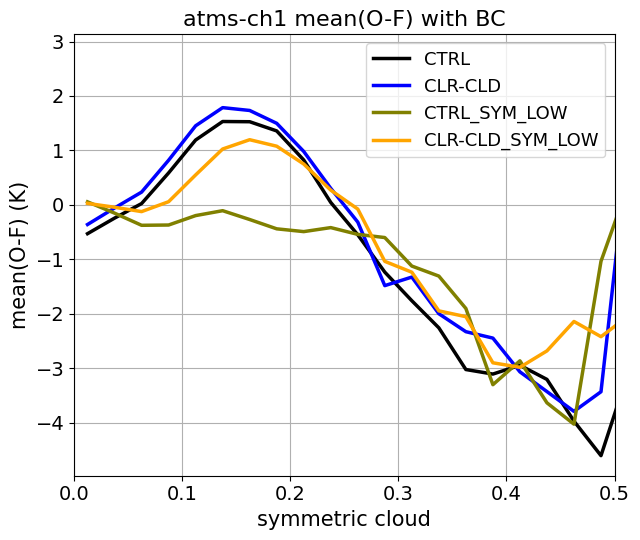

In [29]:
# time average of Hovemoller:
# omf

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])

save_figure = False

# edit this!
exp_list = exps
#exp_list = [exp for exp in exps if exp!='full_sym']


if instrument == 'amsua':
    if channel in ('ch1'):
        vmin = -1
        vmax =  7
    elif channel in ('ch2'):
        vmin =  -2
        vmax =  10
    elif channel in ('ch3'):
        vmin =  -2
        vmax =   7
    elif channel in ('ch4'):
        vmin = -0.5
        vmax =  2.0
    elif channel in ('ch5'):
        vmin = -0.05
        vmax =  0.45
    elif channel in ('ch15'):
        vmin =  -4
        vmax =   10
elif instrument == 'atms':
    if channel in ('ch16'):
        vmin = -4
        vmax =  2
    elif channel in ('ch17'):
        vmin = -0.5
        vmax =  4
    elif channel in ('ch18','ch19','ch20'):
        vmin = -0.5
        vmax =  2.5
    elif channel in ('ch20'):
        vmin = -0.5
        vmax =  2.5  
    elif channel in ('ch21'):
        vmin = -0.5
        vmax =  2.0  
    elif channel in ('ch22'):
        vmin = -0.5
        vmax =  2.0       
    
fig, ax = plt.subplots(figsize=(6.5,5.5))

for e, exp in enumerate(exp_list):
        
    #ax.plot(x_grid, np.nanmean(dic_omf[exp]['Model Cloud'], axis=0), label=f'{exp}')
    #ax.plot(x_grid, np.nanmean(dic_omf[exp]['Obs Cloud'], axis=0), label=f'{exp}')
    ax.plot(x_grid, smoothing(np.nanmean(dic_omf[exp]['Symmetric Cloud'], axis=0)), linewidth=2.5, color=expcolor[exp], label=f'{expshort[exp]}')
        
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('symmetric cloud', fontsize=15)
ax.set_ylabel(rf'mean(O-F) (K)', fontsize=15)
if instrument == 'atms':
    ax.set_xlim([0, 0.5])   

#ax.set_ylim([vmin, vmax])
ax.grid(True)
ax.set_title(rf'{instrument}-{channel} mean(O-F) with BC',fontsize=16)
ax.legend(loc='best',fontsize=13)
plt.tight_layout()
if save_figure:
    plt.savefig(f"{fig_dir}/omf_{instrument}_{channel}_{'-'.join(exp_list)}.png", dpi=300, bbox_inches='tight')

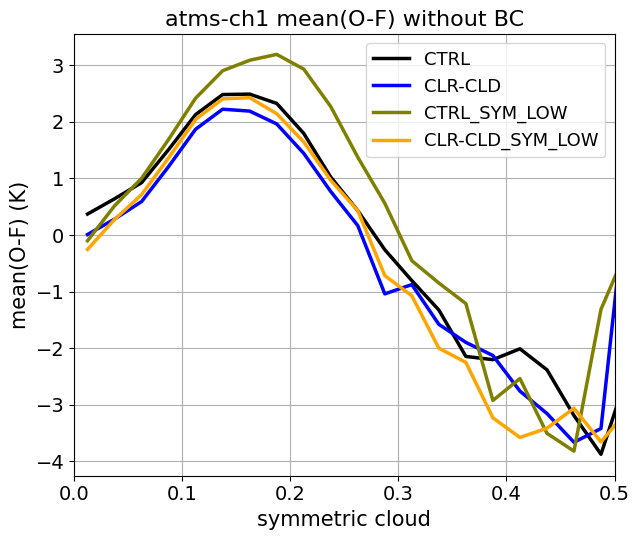

In [30]:
# time average of Hovemoller:
# omfnbc

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])

save_figure = False

# you may edit this
exp_list = exps
#exp_list = [exp for exp in exps if exp!='full_sym']


if instrument == 'amsua':
    if channel in ('ch1'):
        vmin = -1
        vmax =  7
    elif channel in ('ch2'):
        vmin =  -1
        vmax =   8
    elif channel in ('ch3'):
        vmin =  -2
        vmax =   3
    elif channel in ('ch4'):
        vmin = -1.5
        vmax =  0.5
    elif channel in ('ch5'):
        vmin = -0.8
        vmax = -0.0
    elif channel in ('ch15'):
        vmin =  -5
        vmax =   3
elif instrument == 'atms':
    if channel in ('ch16'):
        vmin = -7
        vmax =  2
    elif channel in ('ch17'):
        vmin = -2
        vmax =  5
    elif channel in ('ch18'):
        vmin = -2.0
        vmax =  1.0
        vmax =  5
    elif channel in ('ch19'):
        vmin = -2.0
        vmax =  1.0        
    elif channel in ('ch20'):
        vmin = -1.5
        vmax =    0  
    elif channel in ('ch21'):
        vmin = -1.5
        vmax =    0  
    elif channel in ('ch22'):
        vmin = -1.0
        vmax =  0.5
    
fig, ax = plt.subplots(figsize=(6.5,5.5))

for e, exp in enumerate(exp_list):
        
    if exp != 'full_sym':
        #ax.plot(x_grid, np.nanmean(dic_omfnbc[exp]['Model Cloud'], axis=0), label=f'{exp}')
        #ax.plot(x_grid, np.nanmean(dic_omfnbc[exp]['Obs Cloud'], axis=0), label=f'{exp}')
        ax.plot(x_grid, smoothing(np.nanmean(dic_omfnbc[exp]['Symmetric Cloud'], axis=0)), linewidth=2.5, \
                color=expcolor[exp], label=f'{expshort[exp]}')
        
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('symmetric cloud', fontsize=15)
ax.set_ylabel(rf'mean(O-F) (K)', fontsize=15)
#ax.set_ylim([vmin, vmax])
if instrument == 'atms':
    ax.set_xlim([0, 0.5])
ax.grid(True)
ax.set_title(rf'{instrument}-{channel} mean(O-F) without BC',fontsize=16)
ax.legend(loc='best',fontsize=13)
plt.tight_layout()
if save_figure:
    plt.savefig(f"{fig_dir}/omfnbc_{instrument}_{channel}_{'-'.join(exp_list)}.png", dpi=300, bbox_inches='tight')

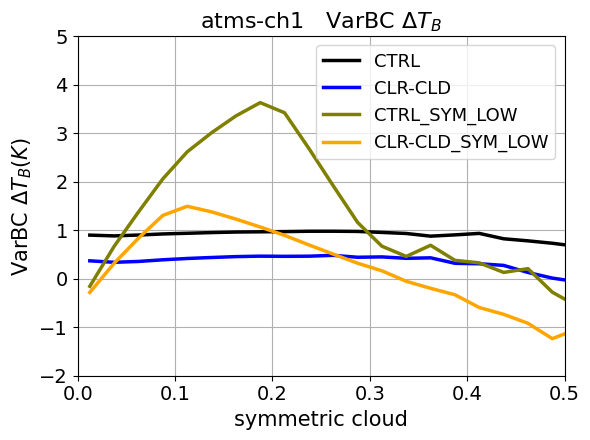

In [31]:
# time average of Hovemoller:
# varbc increment

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])

save_figure = False

# you may edit this
exp_list = exps
#exp_list = [exp for exp in exps if exp!='full_sym']


if instrument == 'amsua':
    if channel in ('ch1'):
        vmin = -4
        vmax =  4
    elif channel in ('ch2'):
        vmin = -6
        vmax =  3
    elif channel in ('ch3'):
        vmin = -5
        vmax =  2
    elif channel in ('ch4'):
        vmin = -2.0
        vmax =    0
    elif channel in ('ch5'):
        vmin = -1.0
        vmax = -0.2
    elif channel in ('ch15'):
        vmin = -10
        vmax =  2
elif instrument == 'atms':
    if channel in ('ch16'):
        vmin = -7
        vmax =  2
    elif channel in ('ch17'):
        vmin = -3
        vmax =  0.5
    elif channel in ('ch18'):
        vmin = -2.5
        vmax = -0.5
    elif channel in ('ch19'):
        vmin = -2.5
        vmax = -0.5     
    elif channel in ('ch20'):
        vmin = -2.0
        vmax = -0.5 
    elif channel in ('ch21'):
        vmin = -1.8
        vmax = -0.5 
    elif channel in ('ch22'):
        vmin = -1.5
        vmax =    0
    
fig, ax = plt.subplots(figsize=(6,4.5))

for e, exp in enumerate(exp_list):
        
    #ax.plot(x_grid, np.nanmean(dic_omfnbc[exp]['Model Cloud'], axis=0), label=f'{exp}')
    #ax.plot(x_grid, np.nanmean(dic_omfnbc[exp]['Obs Cloud'], axis=0), label=f'{exp}')
    ax.plot(x_grid, smoothing(np.nanmean(dic_omfnbc[exp]['Symmetric Cloud'], axis=0)) - \
                    smoothing(np.nanmean(dic_omf[exp]['Symmetric Cloud'], axis=0)), \
            linewidth=2.5, color=expcolor[exp], label=f'{expshort[exp]}')
    
        
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('symmetric cloud', fontsize=15)
ax.set_ylabel(rf'VarBC $\Delta T_B (K)$', fontsize=15)
ax.set_ylim(-2,5)
#ax.set_ylim([vmin, vmax])
if instrument == 'atms':
    ax.set_xlim([0, 0.5])
ax.grid(True)
ax.set_title(rf'{instrument}-{channel}   VarBC $\Delta T_B$',fontsize=16)
ax.legend(loc='best', fontsize=13)
plt.tight_layout()
if save_figure:
    plt.savefig(f"{fig_dir}/varbc_inc_{instrument}_{channel}_{'-'.join(exp_list)}.png", dpi=300, bbox_inches='tight')

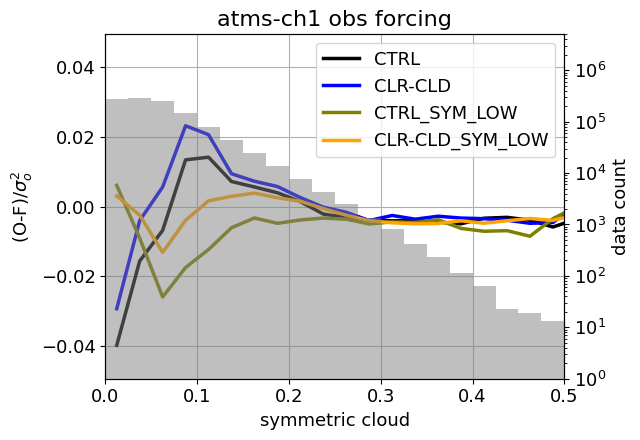

In [32]:
# time average of Hovemoller:
# normalized omf

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])

save_figure = False

# edit this!
exp_list = exps
#exp_list = [exp for exp in exps if exp!='full_sym']
    
fig, ax = plt.subplots(figsize=(6.5,4.5))

for e, exp in enumerate(exp_list):
        
    #ax.plot(x_grid, np.nanmean(dic_omf[exp]['Model Cloud'], axis=0), label=f'{exp}')
    #ax.plot(x_grid, np.nanmean(dic_omf[exp]['Obs Cloud'], axis=0), label=f'{exp}')
    ax.plot(x_grid, smoothing(np.nanmean(dic_omfnorm[exp]['Symmetric Cloud'], axis=0)), linewidth=2.5, \
            color=expcolor[exp], label=f'{expshort[exp]}')
        
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('symmetric cloud', fontsize=13)
ax.set_ylabel(rf'(O-F)/$\sigma_o^2$', fontsize=13)
if instrument == 'atms':
    ax.set_xlim([0, 0.5])   
    
ymin = plt.gca().get_ylim()[0]*1.15
ymax = plt.gca().get_ylim()[1]*1.15
yrange = max(abs(ymin), abs(ymax))
ax.set_ylim(-yrange, yrange)    

ax.grid(True)
ax.set_title(rf'{instrument}-{channel} obs forcing',fontsize=16)
ax.legend(loc='best', fontsize=13)

ax2 = ax.twinx()
ax2.bar(x_grid, np.sum(dic_ndata[exps[0]]['Symmetric Cloud'],axis=0), width=0.025, color=(0.5, 0.5, 0.5), alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylim(1,5e6)
ax2.set_ylabel('data count', fontsize=13)
ax2.tick_params(axis='both', labelsize=13)

plt.tight_layout()
if save_figure:
    plt.savefig(f"{fig_dir}/omfnorm_{instrument}_{channel}_{'-'.join(exp_list)}.png", dpi=300, bbox_inches='tight')

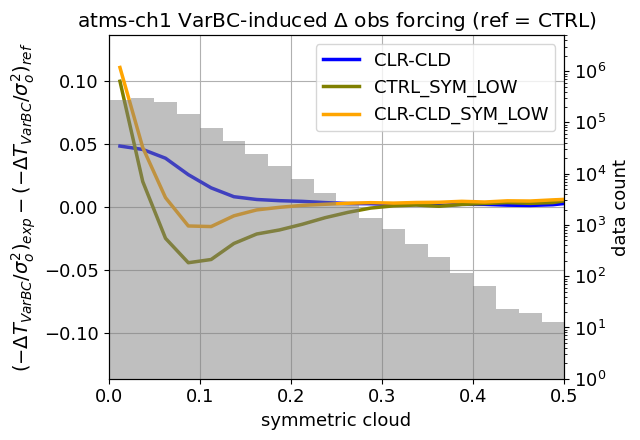

In [33]:
# time average of Hovemoller:
# normalized varbc increment

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])

save_figure = True

# edit this!
exp_list = [exp for exp in exps if exp!=expref]
    
fig, ax = plt.subplots(figsize=(6.5,4.5))
expref = 'full_CTRL'
for e, exp in enumerate(exp_list):
        
    ax.plot(x_grid,  (smoothing(np.nanmean(dic_omfnorm[exp]['Symmetric Cloud'], axis=0))    - smoothing(np.nanmean(dic_omfnbcnorm[exp]['Symmetric Cloud'], axis=0)) )\
                   - (smoothing(np.nanmean(dic_omfnorm[expref]['Symmetric Cloud'], axis=0)) - smoothing(np.nanmean(dic_omfnbcnorm[expref]['Symmetric Cloud'], axis=0)) )\
            ,linewidth=2.5, color=expcolor[exp], label=f'{expshort[exp]}')


ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('symmetric cloud', fontsize=13)
ax.set_ylabel(rf'$(-\Delta T_{{VarBC}}/\sigma_o^2)_{{exp}} - (-\Delta T_{{VarBC}}/\sigma_o^2)_{{ref}}$', fontsize=14)
if instrument == 'atms':
    ax.set_xlim([0, 0.5])   
    
ymin = plt.gca().get_ylim()[0]*1.15
ymax = plt.gca().get_ylim()[1]*1.15
yrange = max(abs(ymin), abs(ymax))
ax.set_ylim(-yrange, yrange)    
ax.grid(True)
ax.set_title(rf'{instrument}-{channel} VarBC-induced $\Delta$ obs forcing (ref = {expshort[expref]})',fontsize=14.5)
ax.legend(loc='best', fontsize=13)

ax2 = ax.twinx()
ax2.bar(x_grid, np.sum(dic_ndata[exps[0]]['Symmetric Cloud'],axis=0), width=0.025, color=(0.5, 0.5, 0.5), alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylim(1,5e6)
ax2.set_ylabel('data count', fontsize=13)
ax2.tick_params(axis='both', labelsize=13)

plt.tight_layout()
if save_figure:
    plt.savefig(f"{fig_dir}/varbc_inc_norm_{instrument}_{channel}_{'-'.join(exp_list)}.png", dpi=300, bbox_inches='tight')

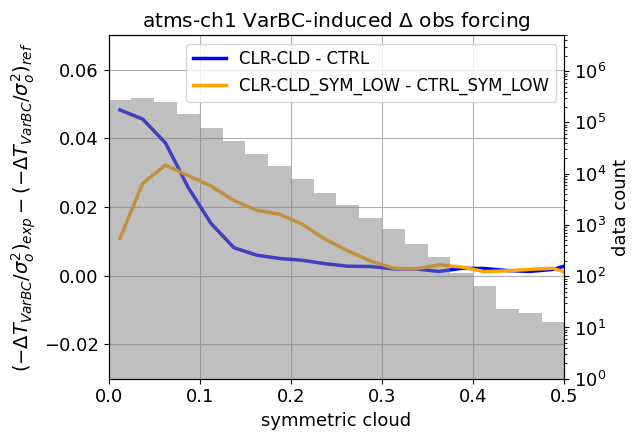

In [34]:
# Revised Figure 14 (compare CLR-CLD to CTRL & CLR-CLD_SYM_LOW to CTRL_SYM_LOW)
# 2025/07/30

# time average of Hovemoller:
# normalized varbc increment

x_grid = 0.5*(x_cld[:-1] + x_cld[1:])

save_figure = False

fig, ax = plt.subplots(figsize=(6.5,4.5))

# edit this!
#exp_list = [exp for exp in exps if exp!=expref]
exp_list = ['full_clr_cld']
expref   = 'full_CTRL'
for e, exp in enumerate(exp_list):
        
    ax.plot(x_grid,  (smoothing(np.nanmean(dic_omfnorm[exp]['Symmetric Cloud'], axis=0))    - smoothing(np.nanmean(dic_omfnbcnorm[exp]['Symmetric Cloud'], axis=0)) )\
                   - (smoothing(np.nanmean(dic_omfnorm[expref]['Symmetric Cloud'], axis=0)) - smoothing(np.nanmean(dic_omfnbcnorm[expref]['Symmetric Cloud'], axis=0)) )\
            ,linewidth=2.5, color=expcolor[exp], label=f'{expshort[exp]} - {expshort[expref]}')

exp_list = ['full_low_sym_tri']
expref   = 'full_CTRL_low_sym'
for e, exp in enumerate(exp_list):
        
    ax.plot(x_grid,  (smoothing(np.nanmean(dic_omfnorm[exp]['Symmetric Cloud'], axis=0))    - smoothing(np.nanmean(dic_omfnbcnorm[exp]['Symmetric Cloud'], axis=0)) )\
                   - (smoothing(np.nanmean(dic_omfnorm[expref]['Symmetric Cloud'], axis=0)) - smoothing(np.nanmean(dic_omfnbcnorm[expref]['Symmetric Cloud'], axis=0)) )\
            ,linewidth=2.5, color=expcolor[exp], label=f'{expshort[exp]} - {expshort[expref]}')

ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('symmetric cloud', fontsize=13)
ax.set_ylabel(rf'$(-\Delta T_{{VarBC}}/\sigma_o^2)_{{exp}} - (-\Delta T_{{VarBC}}/\sigma_o^2)_{{ref}}$', fontsize=14)
if instrument == 'atms':
    ax.set_xlim([0, 0.5])   
    
#ymin = plt.gca().get_ylim()[0]*1.15
#ymax = plt.gca().get_ylim()[1]*1.15
#yrange = max(abs(ymin), abs(ymax))
#ax.set_ylim(-yrange, yrange)    
ax.set_ylim(-0.03, 0.07)    

ax.grid(True)
ax.set_title(rf'{instrument}-{channel} VarBC-induced $\Delta$ obs forcing',fontsize=14.5)
ax.legend(loc='upper right', fontsize=12)

ax2 = ax.twinx()
ax2.bar(x_grid, np.sum(dic_ndata[exps[0]]['Symmetric Cloud'],axis=0), width=0.025, color=(0.5, 0.5, 0.5), alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylim(1,5e6)
ax2.set_ylabel('data count', fontsize=13)
ax2.tick_params(axis='both', labelsize=13)

plt.tight_layout()
if save_figure:
    plt.savefig(f"{fig_dir}/varbc_inc_norm_{instrument}_{channel}_{'-'.join(exp_list)}.png", dpi=300, bbox_inches='tight')